# Final Project - UNETR
## Quantization comparison

## imports


In [10]:
import torch
import torch.quantization as quantization
import os
import time
import numpy as np
import monai

## Model architecture

In [11]:
# Copyright 2020 - 2021 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from typing import Tuple, Union

import torch
import torch.nn as nn

from monai.networks.blocks import UnetrBasicBlock, UnetrPrUpBlock, UnetrUpBlock
from monai.networks.blocks.dynunet_block import UnetOutBlock
from monai.networks.nets import ViT


class UNETR(nn.Module):
    """
    UNETR based on: "Hatamizadeh et al.,
    UNETR: Transformers for 3D Medical Image Segmentation <https://arxiv.org/abs/2103.10504>"
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        img_size: Tuple[int, int, int],
        feature_size: int = 16,
        hidden_size: int = 768,
        mlp_dim: int = 3072,
        num_heads: int = 12,
        pos_embed: str = "perceptron",
        norm_name: Union[Tuple, str] = "instance",
        conv_block: bool = False,
        res_block: bool = True,
        dropout_rate: float = 0.0,
    ) -> None:
        """
        Args:
            in_channels: dimension of input channels.
            out_channels: dimension of output channels.
            img_size: dimension of input image.
            feature_size: dimension of network feature size.
            hidden_size: dimension of hidden layer.
            mlp_dim: dimension of feedforward layer.
            num_heads: number of attention heads.
            pos_embed: position embedding layer type.
            norm_name: feature normalization type and arguments.
            conv_block: bool argument to determine if convolutional block is used.
            res_block: bool argument to determine if residual block is used.
            dropout_rate: faction of the input units to drop.

        Examples::

            # for single channel input 4-channel output with patch size of (96,96,96), feature size of 32 and batch norm
            >>> net = UNETR(in_channels=1, out_channels=4, img_size=(96,96,96), feature_size=32, norm_name='batch')

            # for 4-channel input 3-channel output with patch size of (128,128,128), conv position embedding and instance norm
            >>> net = UNETR(in_channels=4, out_channels=3, img_size=(128,128,128), pos_embed='conv', norm_name='instance')

        """

        super().__init__()

        if not (0 <= dropout_rate <= 1):
            raise AssertionError("dropout_rate should be between 0 and 1.")

        if hidden_size % num_heads != 0:
            raise AssertionError("hidden size should be divisible by num_heads.")

        if pos_embed not in ["conv", "perceptron"]:
            raise KeyError(f"Position embedding layer of type {pos_embed} is not supported.")

        self.num_layers = 12
        self.patch_size = (16, 16, 16)
        self.feat_size = (
            img_size[0] // self.patch_size[0],
            img_size[1] // self.patch_size[1],
            img_size[2] // self.patch_size[2],
        )
        self.hidden_size = hidden_size
        self.classification = False
        self.vit = ViT(
            in_channels=in_channels,
            img_size=img_size,
            patch_size=self.patch_size,
            hidden_size=hidden_size,
            mlp_dim=mlp_dim,
            num_layers=self.num_layers,
            num_heads=num_heads,
            pos_embed=pos_embed,
            classification=self.classification,
            dropout_rate=dropout_rate,
        )
        self.encoder1 = UnetrBasicBlock(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=feature_size,
            kernel_size=3,
            stride=1,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.encoder2 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 2,
            num_layer=2,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder3 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 4,
            num_layer=1,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.encoder4 = UnetrPrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            num_layer=0,
            kernel_size=3,
            stride=1,
            upsample_kernel_size=2,
            norm_name=norm_name,
            conv_block=conv_block,
            res_block=res_block,
        )
        self.decoder5 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=hidden_size,
            out_channels=feature_size * 8,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder4 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 8,
            out_channels=feature_size * 4,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder3 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 4,
            out_channels=feature_size * 2,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.decoder2 = UnetrUpBlock(
            spatial_dims=3,
            in_channels=feature_size * 2,
            out_channels=feature_size,
            kernel_size=3,
            upsample_kernel_size=2,
            norm_name=norm_name,
            res_block=res_block,
        )
        self.out = UnetOutBlock(spatial_dims=3, in_channels=feature_size, out_channels=out_channels)  # type: ignore

    def proj_feat(self, x, hidden_size, feat_size):
        x = x.view(x.size(0), feat_size[0], feat_size[1], feat_size[2], hidden_size)
        x = x.permute(0, 4, 1, 2, 3).contiguous()
        return x

    def load_from(self, weights):
        with torch.no_grad():
            res_weight = weights
            # copy weights from patch embedding
            for i in weights["state_dict"]:
                print(i)
            self.vit.patch_embedding.position_embeddings.copy_(
                weights["state_dict"]["module.transformer.patch_embedding.position_embeddings_3d"]
            )
            self.vit.patch_embedding.cls_token.copy_(
                weights["state_dict"]["module.transformer.patch_embedding.cls_token"]
            )
            self.vit.patch_embedding.patch_embeddings[1].weight.copy_(
                weights["state_dict"]["module.transformer.patch_embedding.patch_embeddings.1.weight"]
            )
            self.vit.patch_embedding.patch_embeddings[1].bias.copy_(
                weights["state_dict"]["module.transformer.patch_embedding.patch_embeddings.1.bias"]
            )

            # copy weights from  encoding blocks (default: num of blocks: 12)
            for bname, block in self.vit.blocks.named_children():
                print(block)
                block.loadFrom(weights, n_block=bname)
            # last norm layer of transformer
            self.vit.norm.weight.copy_(weights["state_dict"]["module.transformer.norm.weight"])
            self.vit.norm.bias.copy_(weights["state_dict"]["module.transformer.norm.bias"])

    def forward(self, x_in):
        x, hidden_states_out = self.vit(x_in)
        enc1 = self.encoder1(x_in)
        x2 = hidden_states_out[3]
        enc2 = self.encoder2(self.proj_feat(x2, self.hidden_size, self.feat_size))
        x3 = hidden_states_out[6]
        enc3 = self.encoder3(self.proj_feat(x3, self.hidden_size, self.feat_size))
        x4 = hidden_states_out[9]
        enc4 = self.encoder4(self.proj_feat(x4, self.hidden_size, self.feat_size))
        dec4 = self.proj_feat(x, self.hidden_size, self.feat_size)
        dec3 = self.decoder5(dec4, enc4)
        dec2 = self.decoder4(dec3, enc3)
        dec1 = self.decoder3(dec2, enc2)
        out = self.decoder2(dec1, enc1)
        logits = self.out(out)
        return logits

## Utils:
* data_utils.py
* utils.py

In [12]:
####################
#      utils       #
####################

import numpy as np
import torch


def dice(x, y):
    intersect = np.sum(np.sum(np.sum(x * y)))
    y_sum = np.sum(np.sum(np.sum(y)))
    if y_sum == 0:
        return 0.0
    x_sum = np.sum(np.sum(np.sum(x)))
    return 2 * intersect / (x_sum + y_sum)


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)


def distributed_all_gather(
    tensor_list, valid_batch_size=None, out_numpy=False, world_size=None, no_barrier=False, is_valid=None
):
    if world_size is None:
        world_size = torch.distributed.get_world_size()
    if valid_batch_size is not None:
        valid_batch_size = min(valid_batch_size, world_size)
    elif is_valid is not None:
        is_valid = torch.tensor(bool(is_valid), dtype=torch.bool, device=tensor_list[0].device)
    if not no_barrier:
        torch.distributed.barrier()
    tensor_list_out = []
    with torch.no_grad():
        if is_valid is not None:
            is_valid_list = [torch.zeros_like(is_valid) for _ in range(world_size)]
            torch.distributed.all_gather(is_valid_list, is_valid)
            is_valid = [x.item() for x in is_valid_list]
        for tensor in tensor_list:
            gather_list = [torch.zeros_like(tensor) for _ in range(world_size)]
            torch.distributed.all_gather(gather_list, tensor)
            if valid_batch_size is not None:
                gather_list = gather_list[:valid_batch_size]
            elif is_valid is not None:
                gather_list = [g for g, v in zip(gather_list, is_valid_list) if v]
            if out_numpy:
                gather_list = [t.cpu().numpy() for t in gather_list]
            tensor_list_out.append(gather_list)
    return tensor_list_out

In [13]:
##################
#   data_utils   #
##################

import math
import os

import numpy as np
import torch

from monai import data, transforms
from monai.data import load_decathlon_datalist


class Sampler(torch.utils.data.Sampler):
    def __init__(self, dataset, num_replicas=None, rank=None, shuffle=True, make_even=True):
        if num_replicas is None:
            if not torch.distributed.is_available():
                raise RuntimeError("Requires distributed package to be available")
            num_replicas = torch.distributed.get_world_size()
        if rank is None:
            if not torch.distributed.is_available():
                raise RuntimeError("Requires distributed package to be available")
            rank = torch.distributed.get_rank()
        self.shuffle = shuffle
        self.make_even = make_even
        self.dataset = dataset
        self.num_replicas = num_replicas
        self.rank = rank
        self.epoch = 0
        self.num_samples = int(math.ceil(len(self.dataset) * 1.0 / self.num_replicas))
        self.total_size = self.num_samples * self.num_replicas
        indices = list(range(len(self.dataset)))
        self.valid_length = len(indices[self.rank : self.total_size : self.num_replicas])

    def __iter__(self):
        if self.shuffle:
            g = torch.Generator()
            g.manual_seed(self.epoch)
            indices = torch.randperm(len(self.dataset), generator=g).tolist()
        else:
            indices = list(range(len(self.dataset)))
        if self.make_even:
            if len(indices) < self.total_size:
                if self.total_size - len(indices) < len(indices):
                    indices += indices[: (self.total_size - len(indices))]
                else:
                    extra_ids = np.random.randint(low=0, high=len(indices), size=self.total_size - len(indices))
                    indices += [indices[ids] for ids in extra_ids]
            assert len(indices) == self.total_size
        indices = indices[self.rank : self.total_size : self.num_replicas]
        self.num_samples = len(indices)
        return iter(indices)

    def __len__(self):
        return self.num_samples

    def set_epoch(self, epoch):
        self.epoch = epoch


def get_loader(args):
    data_dir = args.data_dir
    datalist_json = os.path.join(data_dir, args.json_list)
    train_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            #transforms.AddChanneld(keys=["image", "label"]),
            transforms.EnsureChannelFirstd(keys=["image", "label"]),

            transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
            transforms.Spacingd(
                keys=["image", "label"], pixdim=(args.space_x, args.space_y, args.space_z), mode=("bilinear", "nearest")
            ),
            transforms.ScaleIntensityRanged(
                keys=["image"], a_min=args.a_min, a_max=args.a_max, b_min=args.b_min, b_max=args.b_max, clip=True
            ),
            transforms.CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
            transforms.RandCropByPosNegLabeld(
                keys=["image", "label"],
                label_key="label",
                spatial_size=(args.roi_x, args.roi_y, args.roi_z),
                pos=1,
                neg=1,
                num_samples=4,
                image_key="image",
                image_threshold=0,
            ),
            transforms.RandFlipd(keys=["image", "label"], prob=args.RandFlipd_prob, spatial_axis=0),
            transforms.RandFlipd(keys=["image", "label"], prob=args.RandFlipd_prob, spatial_axis=1),
            transforms.RandFlipd(keys=["image", "label"], prob=args.RandFlipd_prob, spatial_axis=2),
            transforms.RandRotate90d(keys=["image", "label"], prob=args.RandRotate90d_prob, max_k=3),
            transforms.RandScaleIntensityd(keys="image", factors=0.1, prob=args.RandScaleIntensityd_prob),
            transforms.RandShiftIntensityd(keys="image", offsets=0.1, prob=args.RandShiftIntensityd_prob),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )
    val_transform = transforms.Compose(
        [
            transforms.LoadImaged(keys=["image", "label"]),
            #transforms.AddChanneld(keys=["image", "label"]),
            transforms.EnsureChannelFirstd(keys=["image", "label"]),
            transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
            transforms.Spacingd(
                keys=["image", "label"], pixdim=(args.space_x, args.space_y, args.space_z), mode=("bilinear", "nearest")
            ),
            transforms.ScaleIntensityRanged(
                keys=["image"], a_min=args.a_min, a_max=args.a_max, b_min=args.b_min, b_max=args.b_max, clip=True
            ),
            transforms.CropForegroundd(keys=["image", "label"], source_key="image", allow_smaller=True),
            transforms.ToTensord(keys=["image", "label"]),
        ]
    )

    if args.test_mode:
        test_files = load_decathlon_datalist(datalist_json, True, "validation", base_dir=data_dir)
        test_ds = data.Dataset(data=test_files, transform=val_transform)
        test_sampler = Sampler(test_ds, shuffle=False) if args.distributed else None
        test_loader = data.DataLoader(
            test_ds,
            batch_size=1,
            shuffle=False,
            num_workers=args.workers,
            sampler=test_sampler,
            pin_memory=True,
            persistent_workers=True,
        )
        loader = test_loader
    else:
        datalist = load_decathlon_datalist(datalist_json, True, "training", base_dir=data_dir)
        if args.use_normal_dataset:
            train_ds = data.Dataset(data=datalist, transform=train_transform)
        else:
            train_ds = data.CacheDataset(
                data=datalist, transform=train_transform, cache_num=24, cache_rate=1.0, num_workers=args.workers
            )
        train_sampler = Sampler(train_ds) if args.distributed else None
        train_loader = data.DataLoader(
            train_ds,
            batch_size=args.batch_size,
            shuffle=(train_sampler is None),
            num_workers=args.workers,
            sampler=train_sampler,
            pin_memory=True,
            persistent_workers=True,
        )
        val_files = load_decathlon_datalist(datalist_json, True, "validation", base_dir=data_dir)
        val_ds = data.Dataset(data=val_files, transform=val_transform)
        val_sampler = Sampler(val_ds, shuffle=False) if args.distributed else None
        val_loader = data.DataLoader(
            val_ds,
            batch_size=1,
            shuffle=False,
            num_workers=args.workers,
            sampler=val_sampler,
            pin_memory=True,
            persistent_workers=True,
        )
        loader = [train_loader, val_loader]

    return loader


## loading pretrained model &Running Quantization

In [14]:
import torch
import os

class UNETRQuantizer:
    def __init__(self, pretrained_path="./pretrained_models/UNETR_model_best_acc.pth"):
        self.pretrained_path = pretrained_path

    def load_original_model(self):
        """Load the original pretrained UNETR model"""
        print(" Loading original UNETR model...")

        model = UNETR(
            in_channels=1,
            out_channels=14,
            img_size=(96, 96, 96),
            feature_size=16,
            hidden_size=768,
            mlp_dim=3072,
            num_heads=12,
            #pos_embed='perceptron',
            norm_name='instance',
            conv_block=True,
            res_block=True,
            dropout_rate=0.0
        )

        # Load pretrained weights
        model_dict = torch.load(self.pretrained_path, map_location='cpu')
        model.load_state_dict(model_dict, strict=False)
        model.eval()

        print(" Original model loaded successfully")
        return model

    def get_model_size(self, model, name="model"):
        """Calculate model size in MB"""
        temp_path = f"temp_{name}.pth"
        torch.save(model.state_dict(), temp_path)
        size_mb = os.path.getsize(temp_path) / (1024 * 1024)
        os.remove(temp_path)
        return size_mb

    def create_int8_model(self, original_model):
        """Apply INT8 dynamic quantization"""

        # Create a copy of the model
        model_copy = UNETR(
            in_channels=1, out_channels=14, img_size=(96, 96, 96),
            feature_size=16, hidden_size=768, mlp_dim=3072,
            num_heads=12, pos_embed='perceptron', norm_name='instance',
            conv_block=True, res_block=True, dropout_rate=0.0
        )
        model_copy.load_state_dict(original_model.state_dict())
        model_copy.eval()

        # Apply dynamic quantization
        quantized_model = torch.quantization.quantize_dynamic(
            model_copy,
            {torch.nn.Linear, torch.nn.Conv3d},
            dtype=torch.qint8
        )

        return quantized_model

    def create_fp16_model(self, original_model):
        """Apply FP16 quantization"""

        model_fp16 = original_model.cpu().half()
        return model_fp16

    def save_all_models(self, original_model):
        """Save original and quantized models"""
        os.makedirs("quantized_models", exist_ok=True)

        print("\n Model Sizes:")

        # Original model size
        original_size = self.get_model_size(original_model, "original")
        print(f"Original: {original_size:.2f} MB")

        # Create and save INT8 model
        try:
            int8_model = self.create_int8_model(original_model)
            int8_path = "quantized_models/unetr_int8_quantized.pth"
            torch.save(int8_model.state_dict(), int8_path)
            int8_size = self.get_model_size(int8_model, "int8")

            print(f"  INT8:     {int8_size:.2f} MB ({original_size/int8_size:.1f}x smaller)")
            print(f"  Saved: {int8_path}")

        except Exception as e:
            print(f" INT8 failed: {e}")

        # Create and save FP16 model
        try:
            fp16_model = self.create_fp16_model(original_model)
            fp16_path = "quantized_models/unetr_fp16_quantized.pth"
            torch.save(fp16_model.state_dict(), fp16_path)
            fp16_size = self.get_model_size(fp16_model, "fp16")

            print(f"  FP16:     {fp16_size:.2f} MB ({original_size/fp16_size:.1f}x smaller)")
            print(f"  Saved: {fp16_path}")

        except Exception as e:
            print(f"  FP16 failed: {e}")

In [15]:
print("UNETR Model Quantization")

# Check if original model exists
original_path = "pretrained_models/UNETR_model_best_acc.pth"

# Initialize quantizer
quantizer = UNETRQuantizer(original_path)

# Load original model
original_model = quantizer.load_original_model()

# Quantize and save all models
quantizer.save_all_models(original_model)

# Create usage guide
# quantizer.create_usage_guide() # This method does not exist, commenting it out

print(f"\n Quantization Complete!")
print(f" All models saved in: ./quantized_models/")

UNETR Model Quantization
 Loading original UNETR model...


/var/folders/3g/8s4nmsgx1lv5wd6ttt2_mwtc0000gn/T/ipykernel_54101/2734479439.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(self.pretrained_path

 Original model loaded successfully

 Model Sizes:
Original: 354.01 MB
 INT8 failed: Didn't find engine for operation quantized::linear_prepack NoQEngine
  FP16:     177.04 MB (2.0x smaller)
  Saved: quantized_models/unetr_fp16_quantized.pth

 Quantization Complete!
 All models saved in: ./quantized_models/


## inference , comparison, and segmenation

In [16]:
import os
import time
import json
import numpy as np
import pandas as pd
import torch
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.metrics import HausdorffDistanceMetric
from scipy.spatial.distance import directed_hausdorff
from scipy import ndimage
import glob

def create_organ_colormap():
    """Create colormap for 14 organs with transparency for overlay"""
    colors = [
        [0, 0, 0, 0],        # 0: Background (transparent)
        [1, 0, 0, 0.6],      # 1: Spleen (red)
        [0, 1, 0, 0.6],      # 2: Right Kidney (green)
        [0, 0, 1, 0.6],      # 3: Left Kidney (blue)
        [1, 1, 0, 0.6],      # 4: Gallbladder (yellow)
        [1, 0, 1, 0.6],      # 5: Esophagus (magenta)
        [0, 1, 1, 0.6],      # 6: Liver (cyan)
        [1, 0.65, 0, 0.6],   # 7: Stomach (orange)
        [0.5, 0, 0.5, 0.6],  # 8: Aorta (purple)
        [0.65, 0.16, 0.16, 0.6], # 9: IVC (brown)
        [1, 0.75, 0.8, 0.6], # 10: Portal/Splenic Veins (pink)
        [0.5, 0.5, 0.5, 0.6], # 11: Pancreas (gray)
        [0.5, 0.5, 0, 0.6],  # 12: Right Adrenal (olive)
        [0, 0, 0.5, 0.6]     # 13: Left Adrenal (navy)
    ]
    return ListedColormap(colors)

## loading model

In [17]:
def load_model_robust(model_path, model_type, force_gpu=True):
    """Robust model loading with flexible device selection"""
    
    print(f" Loading {model_type.upper()} model...")
    
    try:
        # Create model
        model = UNETR(in_channels=1, out_channels=14, img_size=(96, 96, 96),
                      feature_size=16, hidden_size=768, mlp_dim=3072, num_heads=12,
                      pos_embed="perceptron", norm_name="instance", 
                      conv_block=True, res_block=True, dropout_rate=0.0)
        
        # Load weights
        try:
            model_dict = torch.load(model_path, map_location='cpu', weights_only=False)
        except:
            model_dict = torch.load(model_path, map_location='cpu')
        
        # Handle different checkpoint formats
        if isinstance(model_dict, dict) and 'state_dict' in model_dict:
            state_dict = model_dict['state_dict']
        else:
            state_dict = model_dict
        
        # Clean state dict
        clean_state_dict = {}
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            clean_state_dict[name] = v
        
        model.load_state_dict(clean_state_dict, strict=False)
        model.eval()
        
        # Device selection with fallback
        if model_type == "int8":
            # INT8 always on CPU
            model = torch.quantization.quantize_dynamic(
                model, {torch.nn.Linear, torch.nn.Conv3d}, dtype=torch.qint8
            )
            device = torch.device("cpu")
            print(f"   INT8 on CPU")
        else:
            # Try GPU first, fallback to CPU
            if torch.cuda.is_available() and force_gpu:
                try:
                    device = torch.device("cuda")
                    model = model.to(device)
                    
                    if model_type == "fp16":
                        model = model.half()
                        print(f"   FP16 on GPU")
                    else:
                        print(f"   ORIGINAL on GPU")
                        
                    # Test with small tensor
                    test_input = torch.randn(1, 1, 32, 32, 32).to(device)
                    if model_type == "fp16":
                        test_input = test_input.half()
                    
                    with torch.no_grad():
                        _ = model(test_input)
                    
                    del test_input
                    torch.cuda.empty_cache()
                    print(f"    GPU test successful")
                    
                except Exception as e:
                    print(f"    GPU failed ({e}), falling back to CPU")
                    device = torch.device("cpu")
                    model = model.cpu().float()  # Ensure float32 on CPU
            else:
                device = torch.device("cpu")
                model = model.to(device)
                print(f"   {model_type.upper()} on CPU")
        
        return model, device
        
    except Exception as e:
        print(f" Failed to load {model_type}: {e}")
        return None, None

## calc metrics

In [18]:
def calculate_hd95(pred_mask, gt_mask, spacing=(1.5, 1.5, 2.0)):
    """Calculate HD95 distance"""
    if np.sum(pred_mask) == 0 and np.sum(gt_mask) == 0:
        return 0.0
    if np.sum(pred_mask) == 0 or np.sum(gt_mask) == 0:
        return 373.13  # Large penalty

    # Get surface points
    pred_surface = get_surface_points(pred_mask)
    gt_surface = get_surface_points(gt_mask)

    if len(pred_surface) == 0 or len(gt_surface) == 0:
        return 

    # Apply spacing
    pred_surface_mm = pred_surface * np.array(spacing)
    gt_surface_mm = gt_surface * np.array(spacing)

    # Calculate distances
    dist_pred_to_gt = [np.min(np.linalg.norm(gt_surface_mm - p, axis=1)) for p in pred_surface_mm]
    dist_gt_to_pred = [np.min(np.linalg.norm(pred_surface_mm - g, axis=1)) for g in gt_surface_mm]

    all_distances = np.concatenate([dist_pred_to_gt, dist_gt_to_pred])
    return float(np.percentile(all_distances, 95))

def get_surface_points(mask):
    """Extract surface points from binary mask"""
    eroded = ndimage.binary_erosion(mask)
    surface = mask & ~eroded
    surface_coords = np.where(surface)
    return np.column_stack(surface_coords)

# def dice_calculation()
# # Quick Dice calculation only (skip HD95 for speed)
        # dice_scores = []
        
        # for organ_id in range(1, 14):
        #     pred_mask = (pred_seg == organ_id).astype(np.uint8)
        #     gt_mask = (gt_seg == organ_id).astype(np.uint8)
            
        #     if np.sum(gt_mask) == 0 and np.sum(pred_mask) == 0:
        #         dice_score = 1.0
        #     elif np.sum(gt_mask) == 0:
        #         dice_score = 0.0
        #     else:
        #         dice_score = dice(pred_mask, gt_mask)
            
        #     dice_scores.append(dice_score)
        
        # mean_dice = np.mean(dice_scores)
        # mean_hd95 = np.nan  # Skip HD95 for speed
                


## inference

In [19]:
def run_adaptive_inference(model, inputs, labels, device, model_type):
    """Adaptive inference that adjusts patch size based on input"""
    
    try:
        # Clear GPU memory
        if device.type == "cuda":
            torch.cuda.empty_cache()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        if model_type == "fp16" and device.type == "cuda":
            inputs = inputs.half()
        
        # Adaptive patch size based on input dimensions
        input_shape = inputs.shape[2:]  # Remove batch and channel dims
        print(f"     Input shape: {input_shape}")
        
        # Choose patch size that works with your data
        if max(input_shape) > 200:
            # Large inputs - use larger patches
            patch_size = (96, 96, 96)
            batch_size = 2
            overlap = 0.25
        else:
            # Smaller inputs - use smaller patches
            patch_size = (64, 64, 64)
            batch_size = 4
            overlap = 0.25
        
        print(f"     Using patches: {patch_size}, overlap: {overlap}")
        
        # Time inference
        if device.type == "cuda":
            torch.cuda.synchronize()
        
        start_time = time.perf_counter()
        
        with torch.no_grad():
            outputs = sliding_window_inference(
                inputs, patch_size, batch_size, model, overlap=overlap, mode="gaussian"
            )
        
        if device.type == "cuda":
            torch.cuda.synchronize()
        
        inference_time = time.perf_counter() - start_time
        
        # Convert to segmentation
        outputs = torch.softmax(outputs, 1).cpu().numpy()
        pred_seg = np.argmax(outputs, axis=1)[0].astype(np.uint8)
        gt_seg = labels.cpu().numpy()[0, 0, :, :, :]
        
        # Quick Dice calculation only (skip HD95 for speed)
        dice_scores = []
        
        for organ_id in range(1, 14):
            pred_mask = (pred_seg == organ_id).astype(np.uint8)
            gt_mask = (gt_seg == organ_id).astype(np.uint8)
            
            if np.sum(gt_mask) == 0 and np.sum(pred_mask) == 0:
                dice_score = 1.0
            elif np.sum(gt_mask) == 0:
                dice_score = 0.0
            else:
                dice_score = dice(pred_mask, gt_mask)
            
            dice_scores.append(dice_score)
        
        mean_dice = np.mean(dice_scores)
        mean_hd95 = np.nan  # Skip HD95 for speed
                
        return pred_seg, inference_time, mean_dice, mean_hd95
    except Exception as e:
        print(f"Error during adaptive inference: {e}")
        return None, None, None, None

## create_overlay_comparison

In [20]:
def create_overlay_comparison(ct_data, segmentations, case_name, output_dir="./results"):
    """Create overlay comparison"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Normalize CT for display
    ct_display = np.clip(ct_data, -175, 250)
    ct_display = (ct_display - ct_display.min()) / (ct_display.max() - ct_display.min() + 1e-8)
    
    # Get middle slice
    middle_slice_idx = ct_data.shape[2] // 2
    ct_slice = ct_display[:, :, middle_slice_idx]
    
    # Create comparison figure
    n_models = len(segmentations)
    fig, axes = plt.subplots(1, n_models + 1, figsize=(5*(n_models + 1), 5))
    
    if n_models == 1:
        axes = [axes[0], axes[1]]
    elif n_models == 0:
        plt.close()
        return
    
    # Colormap for organs
    from matplotlib.colors import ListedColormap
    colors = ['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan',
              'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'navy']
    cmap = ListedColormap(colors[:14])
    
    # Plot original CT
    axes[0].imshow(ct_slice, cmap='gray', origin='lower')
    axes[0].set_title('Original CT', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # Plot overlays
    for i, (model_name, seg_data) in enumerate(segmentations.items()):
        seg_slice = seg_data[:, :, middle_slice_idx]
        
        axes[i+1].imshow(ct_slice, cmap='gray', origin='lower')
        seg_masked = np.ma.masked_where(seg_slice == 0, seg_slice)
        axes[i+1].imshow(seg_masked, cmap=cmap, vmin=0, vmax=13, alpha=0.6, origin='lower')
        
        axes[i+1].set_title(f'{model_name.upper()} Overlay', fontsize=12, fontweight='bold')
        axes[i+1].axis('off')
    
    plt.suptitle(f'{case_name} - Axial Slice {middle_slice_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    save_path = os.path.join(output_dir, f'{case_name}_overlay_comparison.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"     Saved: {save_path}")

## Inference on validation

In [21]:
# FIXED FAST 6-Case Validation - Resolves tensor size and CUDA issues

import os
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import nibabel as nib
import pandas as pd
from tqdm import tqdm
import time

import torch
import torch.backends.quantized

# Set quantization backend for macOS
try:
    torch.backends.quantized.engine = 'qnnpack'
    print(" Using QNNPACK quantization backend")
except Exception as e:
    print(f" Could not set QNNPACK backend: {e}")
    print("INT8 quantization may not work")

    
# Set fixed seeds to prevent overflow
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

# Monkey patch the problematic MONAI function
import monai.transforms.transform as mt

original_set_random_state = mt.Randomizable.set_random_state

def fixed_set_random_state(self, seed=None, state=None):
    if seed is not None:
        _seed = id(seed) if not isinstance(seed, (int, np.integer)) else seed
        _seed = abs(_seed) % 2147483647
        self.R = np.random.RandomState(_seed)
        return self
    if state is not None:
        self.R.set_state(state)
        return self
    self.R = np.random.RandomState()
    return self

mt.Randomizable.set_random_state = fixed_set_random_state

def check_gpu_status():
    """Check GPU availability and memory"""
    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name()
        total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f" GPU Available: {device_name}")
        print(f" Total GPU Memory: {total_memory:.1f}GB")
        
        # Test GPU with a small tensor
        try:
            test_tensor = torch.randn(1, 1, 32, 32, 32).cuda()
            print(f" GPU test successful")
            del test_tensor
            torch.cuda.empty_cache()
            return True
        except Exception as e:
            print(f" GPU test failed: {e}")
            return False
    else:
        print(f" CUDA not available")
        return False

def load_model_robust(model_path, model_type, force_gpu=True):
    """Robust model loading with flexible device selection"""
    
    print(f" Loading {model_type.upper()} model...")
    
    try:
        # Create model
        model = UNETR(in_channels=1, out_channels=14, img_size=(96, 96, 96),
                      feature_size=16, hidden_size=768, mlp_dim=3072, num_heads=12,
                      pos_embed="perceptron", norm_name="instance", 
                      conv_block=True, res_block=True, dropout_rate=0.0)
        
        # Load weights
        try:
            model_dict = torch.load(model_path, map_location='cpu', weights_only=False)
        except:
            model_dict = torch.load(model_path, map_location='cpu')
        
        # Handle different checkpoint formats
        if isinstance(model_dict, dict) and 'state_dict' in model_dict:
            state_dict = model_dict['state_dict']
        else:
            state_dict = model_dict
        
        # Clean state dict
        clean_state_dict = {}
        for k, v in state_dict.items():
            name = k[7:] if k.startswith('module.') else k
            clean_state_dict[name] = v
        
        model.load_state_dict(clean_state_dict, strict=False)
        model.eval()
        
        # Device selection with fallback
        if model_type == "int8":
            # INT8 always on CPU
            model = torch.quantization.quantize_dynamic(
                model, {torch.nn.Linear, torch.nn.Conv3d}, dtype=torch.qint8
            )
            device = torch.device("cpu")
            print(f"   INT8 on CPU")
        else:
            # Try GPU first, fallback to CPU
            if torch.cuda.is_available() and force_gpu:
                try:
                    device = torch.device("cuda")
                    model = model.to(device)
                    
                    if model_type == "fp16":
                        model = model.half()
                        print(f"   FP16 on GPU")
                    else:
                        print(f"   ORIGINAL on GPU")
                        
                    # Test with small tensor
                    test_input = torch.randn(1, 1, 32, 32, 32).to(device)
                    if model_type == "fp16":
                        test_input = test_input.half()
                    
                    with torch.no_grad():
                        _ = model(test_input)
                    
                    del test_input
                    torch.cuda.empty_cache()
                    print(f"    GPU test successful")
                    
                except Exception as e:
                    print(f"    GPU failed ({e}), falling back to CPU")
                    device = torch.device("cpu")
                    model = model.cpu().float()  # Ensure float32 on CPU
            else:
                device = torch.device("cpu")
                model = model.to(device)
                print(f"   {model_type.upper()} on CPU")
        
        return model, device
        
    except Exception as e:
        print(f" Failed to load {model_type}: {e}")
        return None, None

# def run_adaptive_inference(model, inputs, labels, device, model_type):
#     """Adaptive inference that adjusts patch size based on input"""
    
#     try:
#         # Clear GPU memory
#         if device.type == "cuda":
#             torch.cuda.empty_cache()
        
#         inputs = inputs.to(device)
#         labels = labels.to(device)
        
        # if model_type == "fp16" and device.type == "cuda":
        #     inputs = inputs.half()
        
        # # Adaptive patch size based on input dimensions
        # input_shape = inputs.shape[2:]  # Remove batch and channel dims
        # print(f"     Input shape: {input_shape}")
        
        # # Choose patch size that works with your data
        # if max(input_shape) > 200:
        #     # Large inputs - use larger patches
        #     patch_size = (96, 96, 96)
        #     batch_size = 2
        #     overlap = 0.25
        # else:
        #     # Smaller inputs - use smaller patches
        #     patch_size = (64, 64, 64)
        #     batch_size = 4
        #     overlap = 0.25
        
        # print(f"     Using patches: {patch_size}, overlap: {overlap}")
        
        # # Time inference
        # if device.type == "cuda":
        #     torch.cuda.synchronize()
        
        # start_time = time.perf_counter()
        
        # with torch.no_grad():
        #     outputs = sliding_window_inference(
        #         inputs, patch_size, batch_size, model, overlap=overlap, mode="gaussian"
        #     )
        
        # if device.type == "cuda":
        #     torch.cuda.synchronize()
        
        # inference_time = time.perf_counter() - start_time
        
        # # Convert to segmentation
        # outputs = torch.softmax(outputs, 1).cpu().numpy()
        # pred_seg = np.argmax(outputs, axis=1)[0].astype(np.uint8)
        # gt_seg = labels.cpu().numpy()[0, 0, :, :, :]
        
        # # Quick Dice calculation only (skip HD95 for speed)
        # dice_scores = []
        
        # for organ_id in range(1, 14):
        #     pred_mask = (pred_seg == organ_id).astype(np.uint8)
        #     gt_mask = (gt_seg == organ_id).astype(np.uint8)
            
        #     if np.sum(gt_mask) == 0 and np.sum(pred_mask) == 0:
        #         dice_score = 1.0
        #     elif np.sum(gt_mask) == 0:
        #         dice_score = 0.0
        #     else:
        #         dice_score = dice(pred_mask, gt_mask)
            
        #     dice_scores.append(dice_score)
        
        # mean_dice = np.mean(dice_scores)
        # mean_hd95 = np.nan  # Skip HD95 for speed
                
        # return pred_seg, inference_time, mean_dice, mean_hd95
        
    # except Exception as e:
    #     print(f"     Inference error: {e}")
    #     return None, None, None, None

# def create_overlay_comparison(ct_data, segmentations, case_name, output_dir="./results"):
#     """Create overlay comparison"""
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Normalize CT for display
#     ct_display = np.clip(ct_data, -175, 250)
#     ct_display = (ct_display - ct_display.min()) / (ct_display.max() - ct_display.min() + 1e-8)
    
#     # Get middle slice
#     middle_slice_idx = ct_data.shape[2] // 2
#     ct_slice = ct_display[:, :, middle_slice_idx]
    
#     # Create comparison figure
#     n_models = len(segmentations)
#     fig, axes = plt.subplots(1, n_models + 1, figsize=(5*(n_models + 1), 5))
    
#     if n_models == 1:
#         axes = [axes[0], axes[1]]
#     elif n_models == 0:
#         plt.close()
#         return
    
#     # Colormap for organs
#     from matplotlib.colors import ListedColormap
#     colors = ['black', 'red', 'green', 'blue', 'yellow', 'magenta', 'cyan',
#               'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'navy']
#     cmap = ListedColormap(colors[:14])
    
#     # Plot original CT
#     axes[0].imshow(ct_slice, cmap='gray', origin='lower')
#     axes[0].set_title('Original CT', fontsize=12, fontweight='bold')
#     axes[0].axis('off')
    
#     # Plot overlays
#     for i, (model_name, seg_data) in enumerate(segmentations.items()):
#         seg_slice = seg_data[:, :, middle_slice_idx]
        
#         axes[i+1].imshow(ct_slice, cmap='gray', origin='lower')
#         seg_masked = np.ma.masked_where(seg_slice == 0, seg_slice)
#         axes[i+1].imshow(seg_masked, cmap=cmap, vmin=0, vmax=13, alpha=0.6, origin='lower')
        
#         axes[i+1].set_title(f'{model_name.upper()} Overlay', fontsize=12, fontweight='bold')
#         axes[i+1].axis('off')
    
#     plt.suptitle(f'{case_name} - Axial Slice {middle_slice_idx}', fontsize=14, fontweight='bold')
#     plt.tight_layout()
    
#     save_path = os.path.join(output_dir, f'{case_name}_overlay_comparison.png')
#     plt.savefig(save_path, dpi=150, bbox_inches='tight')
#     plt.close()
#     print(f"     Saved: {save_path}")

# print(" FIXED FAST 6-Case UNETR Comparison")
# print("=" * 50)

# Check GPU status first
gpu_available = check_gpu_status()

# Model paths
models = {
    "original": "./pretrained_models/UNETR_model_best_acc.pth",
    "fp16": "./quantized_models/unetr_fp16_quantized.pth",
    "int8": "./quantized_models/unetr_int8_quantized.pth"
}

# Load data with fixed Args class
class Args:
    test_mode = True
    data_dir = "dataset"  
    json_list = "dataset_0copy.json"
    workers = 1
    distributed = False
    space_x = 1.5; space_y = 1.5; space_z = 2.0
    a_min = -175.0; a_max = 250.0; b_min = 0.0; b_max = 1.0
    roi_x = 96; roi_y = 96; roi_z = 96
    # Disable augmentations for speed
    RandFlipd_prob = 0.0; RandRotate90d_prob = 0.0
    RandScaleIntensityd_prob = 0.0; RandShiftIntensityd_prob = 0.0

args = Args()

# Check dataset
if not os.path.exists(args.data_dir):
    print(f" Dataset not found: {args.data_dir}")
    exit()
print(f" Dataset found: {args.data_dir}")

if not os.path.exists(os.path.join(args.data_dir, args.json_list)):
    print(f" JSON not found: {os.path.join(args.data_dir, args.json_list)}")
    exit()
print(f" JSON found: {os.path.join(args.data_dir, args.json_list)}")

# Load data and run inference
try:
    print(" Loading validation data...")
    val_loader = get_loader(args)
    print(" Data loader created")
    
    total_cases = len(val_loader)
    max_cases = min(6, total_cases)
    print(f" Processing {max_cases}/{total_cases} cases")
    
    # Check available models
    available_models = {k: v for k, v in models.items() if os.path.exists(v)}
    print(f" Available models: {list(available_models.keys())}")
    
    if not available_models:
        print(" No models found!")
        exit()
    
    # Results storage
    all_results = []
    all_segmentations = {}
    
    # Process cases
    case_progress = tqdm(
        total=max_cases,
        desc=" Processing Cases",
        unit="cases",
        colour="blue"
    )
    
    for case_idx, batch in enumerate(val_loader):
        if case_idx >= max_cases:
            break
        
        case_name = f"case_{case_idx+1:03d}"
        case_progress.set_description(f" {case_name}")
        
        print(f"\n{'='*50}")
        print(f" {case_name}: {batch['image'].shape}")
        print(f"{'='*50}")
        
        case_segmentations = {}
        
        # Test each model
        for model_type, model_path in available_models.items():
            print(f" Testing {model_type.upper()}...")
            
            try:
                # Load model
                model, device = load_model_robust(model_path, model_type, force_gpu=gpu_available)
                
                if model is not None:
                    # Run inference
                    pred_seg, inf_time, mean_dice, mean_hd95 = run_adaptive_inference(
                        model, batch["image"], batch["label"], device, model_type
                    )
                    
                    if pred_seg is not None:
                        result = {
                            'Case': case_name,
                            'Model': model_type.upper(),
                            'Inference_Time_s': inf_time,
                            'FPS': 1.0 / inf_time,
                            'Mean_Dice': mean_dice,
                            'Mean_HD95_mm': mean_hd95,
                            'Device': str(device)
                        }
                        all_results.append(result)
                        case_segmentations[model_type] = pred_seg
                        
                        print(f"     {model_type.upper()}: Dice={mean_dice:.4f}, Time={inf_time:.1f}s")
                    else:
                        print(f"     {model_type.upper()}: Inference failed")
                else:
                    print(f"     {model_type.upper()}: Model loading failed")
                
                # Clean up memory
                if device and device.type == "cuda":
                    del model
                    torch.cuda.empty_cache()
                    
            except Exception as e:
                print(f"     {model_type.upper()}: {e}")
        
        # Save results for this case
        if case_segmentations:
            all_segmentations[case_name] = case_segmentations
            
            # Create overlay
            ct_data = batch["image"][0, 0].cpu().numpy()
            create_overlay_comparison(ct_data, case_segmentations, case_name)
        
        case_progress.update(1)
    
    case_progress.close()
    
    # Create summary
    if all_results:
        print(f"\n RESULTS SUMMARY")
        print("=" * 40)
        
        df = pd.DataFrame(all_results)
        
        # Summary statistics
        summary_data = []
        for model in df['Model'].unique():
            model_data = df[df['Model'] == model]
            summary_data.append({
                'Model': model,
                'Cases': len(model_data),
                'Mean_Time_s': model_data['Inference_Time_s'].mean(),
                'Std_Time_s': model_data['Inference_Time_s'].std(),
                'Mean_FPS': model_data['FPS'].mean(),
                'Mean_Dice': model_data['Mean_Dice'].mean(),
                'Std_Dice': model_data['Mean_Dice'].std(),
                'Device': model_data['Device'].iloc[0]
            })
        
        summary_df = pd.DataFrame(summary_data)
        
        # Add model sizes
        model_sizes = {"ORIGINAL": 354, "FP16": 177}
        summary_df['Model_Size_MB'] = summary_df['Model'].map(model_sizes)
        
        # Display
        print(summary_df[['Model', 'Cases', 'Mean_Time_s', 'Mean_Dice', 'Std_Dice', 'Device', 'Model_Size_MB']].to_string(index=False, float_format='%.3f'))
        
        # Save results
        os.makedirs('./results', exist_ok=True)
        df.to_csv('./results/detailed_6_cases_fixed.csv', index=False)
        summary_df.to_csv('./results/summary_6_cases_fixed.csv', index=False)
        
        print(f"\n EVALUATION COMPLETE!")
        print(f" Processed: {len(df)} model-case combinations")
        print(f" Results saved to ./results/")
        
        # Performance summary
        for _, row in summary_df.iterrows():
            print(f" {row['Model']}: {row['Mean_Dice']:.4f}±{row['Std_Dice']:.4f} Dice "
                  f"({row['Mean_Time_s']:.1f}s avg, {row['Device']})")
    
    else:
        print(" No successful results")

except Exception as e:
    print(f" Error: {e}")
    import traceback
    traceback.print_exc()

 Using QNNPACK quantization backend
 CUDA not available
 Dataset found: dataset
 JSON found: dataset/dataset_0copy.json
 Loading validation data...
 Data loader created
 Processing 6/6 cases
 Available models: ['original', 'fp16', 'int8']


 case_001:   0%|          | 0/6 [00:05<?, ?cases/s]        


 case_001: torch.Size([1, 1, 314, 214, 234])
 Testing ORIGINAL...
 Loading ORIGINAL model...
   ORIGINAL on CPU
     Input shape: torch.Size([314, 214, 234])
     Using patches: (96, 96, 96), overlap: 0.25
     ORIGINAL: Dice=0.7256, Time=121.6s
 Testing FP16...
 Loading FP16 model...
   FP16 on CPU
     Input shape: torch.Size([314, 214, 234])
     Using patches: (96, 96, 96), overlap: 0.25
     FP16: Dice=0.7255, Time=99.0s
 Testing INT8...
 Loading INT8 model...


/opt/anaconda3/envs/unter/lib/python3.8/site-packages/torch/_utils.py:383: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


   INT8 on CPU
     Input shape: torch.Size([314, 214, 234])
     Using patches: (96, 96, 96), overlap: 0.25


[W813 23:43:02.312750000 qlinear_dynamic.cpp:250] Warning: Currently, qnnpack incorrectly ignores reduce_range when it is set to true; this may change in a future release. (function operator())


     INT8: Dice=0.0314, Time=100.5s


 case_002:  17%|█▋        | 1/6 [05:31<27:37, 331.41s/cases]

     Saved: ./results/case_001_overlay_comparison.png

 case_002: torch.Size([1, 1, 255, 223, 276])
 Testing ORIGINAL...
 Loading ORIGINAL model...
   ORIGINAL on CPU
     Input shape: torch.Size([255, 223, 276])
     Using patches: (96, 96, 96), overlap: 0.25
     ORIGINAL: Dice=0.7380, Time=100.3s
 Testing FP16...
 Loading FP16 model...
   FP16 on CPU
     Input shape: torch.Size([255, 223, 276])
     Using patches: (96, 96, 96), overlap: 0.25
     FP16: Dice=0.7381, Time=96.0s
 Testing INT8...
 Loading INT8 model...
   INT8 on CPU
     Input shape: torch.Size([255, 223, 276])
     Using patches: (96, 96, 96), overlap: 0.25
     INT8: Dice=0.0144, Time=95.6s


 case_003:  33%|███▎      | 2/6 [10:27<20:42, 310.65s/cases]

     Saved: ./results/case_002_overlay_comparison.png

 case_003: torch.Size([1, 1, 238, 190, 246])
 Testing ORIGINAL...
 Loading ORIGINAL model...
   ORIGINAL on CPU
     Input shape: torch.Size([238, 190, 246])
     Using patches: (96, 96, 96), overlap: 0.25
     ORIGINAL: Dice=0.7929, Time=68.5s
 Testing FP16...
 Loading FP16 model...
   FP16 on CPU
     Input shape: torch.Size([238, 190, 246])
     Using patches: (96, 96, 96), overlap: 0.25
     FP16: Dice=0.7929, Time=69.3s
 Testing INT8...
 Loading INT8 model...
   INT8 on CPU
     Input shape: torch.Size([238, 190, 246])
     Using patches: (96, 96, 96), overlap: 0.25
     INT8: Dice=0.0109, Time=75.1s


 case_004:  50%|█████     | 3/6 [14:04<13:23, 267.78s/cases]

     Saved: ./results/case_003_overlay_comparison.png

 case_004: torch.Size([1, 1, 323, 279, 248])
 Testing ORIGINAL...
 Loading ORIGINAL model...
   ORIGINAL on CPU
     Input shape: torch.Size([323, 279, 248])
     Using patches: (96, 96, 96), overlap: 0.25
     ORIGINAL: Dice=0.7282, Time=153.2s
 Testing FP16...
 Loading FP16 model...
   FP16 on CPU
     Input shape: torch.Size([323, 279, 248])
     Using patches: (96, 96, 96), overlap: 0.25
     FP16: Dice=0.7282, Time=154.4s
 Testing INT8...
 Loading INT8 model...
   INT8 on CPU
     Input shape: torch.Size([323, 279, 248])
     Using patches: (96, 96, 96), overlap: 0.25
     INT8: Dice=0.0105, Time=168.8s


 case_005:  67%|██████▋   | 4/6 [22:05<11:44, 352.21s/cases]

     Saved: ./results/case_004_overlay_comparison.png

 case_005: torch.Size([1, 1, 333, 228, 224])
 Testing ORIGINAL...
 Loading ORIGINAL model...
   ORIGINAL on CPU
     Input shape: torch.Size([333, 228, 224])
     Using patches: (96, 96, 96), overlap: 0.25
     ORIGINAL: Dice=0.7961, Time=86.7s
 Testing FP16...
 Loading FP16 model...
   FP16 on CPU
     Input shape: torch.Size([333, 228, 224])
     Using patches: (96, 96, 96), overlap: 0.25
     FP16: Dice=0.7961, Time=90.6s
 Testing INT8...
 Loading INT8 model...
   INT8 on CPU
     Input shape: torch.Size([333, 228, 224])
     Using patches: (96, 96, 96), overlap: 0.25
     INT8: Dice=0.0284, Time=93.0s


 case_006:  83%|████████▎ | 5/6 [26:40<05:24, 324.26s/cases]

     Saved: ./results/case_005_overlay_comparison.png

 case_006: torch.Size([1, 1, 254, 210, 292])
 Testing ORIGINAL...
 Loading ORIGINAL model...
   ORIGINAL on CPU
     Input shape: torch.Size([254, 210, 292])
     Using patches: (96, 96, 96), overlap: 0.25
     ORIGINAL: Dice=0.7476, Time=91.8s
 Testing FP16...
 Loading FP16 model...
   FP16 on CPU
     Input shape: torch.Size([254, 210, 292])
     Using patches: (96, 96, 96), overlap: 0.25
     FP16: Dice=0.7476, Time=97.9s
 Testing INT8...
 Loading INT8 model...
   INT8 on CPU
     Input shape: torch.Size([254, 210, 292])
     Using patches: (96, 96, 96), overlap: 0.25
     INT8: Dice=0.0114, Time=93.5s


 case_006: 100%|██████████| 6/6 [31:28<00:00, 314.73s/cases]

     Saved: ./results/case_006_overlay_comparison.png

 RESULTS SUMMARY
   Model  Cases  Mean_Time_s  Mean_Dice  Std_Dice Device  Model_Size_MB
ORIGINAL      6      103.676      0.755     0.032    cpu        354.000
    FP16      6      101.207      0.755     0.032    cpu        177.000
    INT8      6      104.436      0.018     0.009    cpu            NaN

 EVALUATION COMPLETE!
 Processed: 18 model-case combinations
 Results saved to ./results/
 ORIGINAL: 0.7547±0.0318 Dice (103.7s avg, cpu)
 FP16: 0.7547±0.0318 Dice (101.2s avg, cpu)
 INT8: 0.0178±0.0095 Dice (104.4s avg, cpu)


## Results


UNETR Model Quantization - 6 Case Validation Analysis
Loaded actual validation results: 18 records


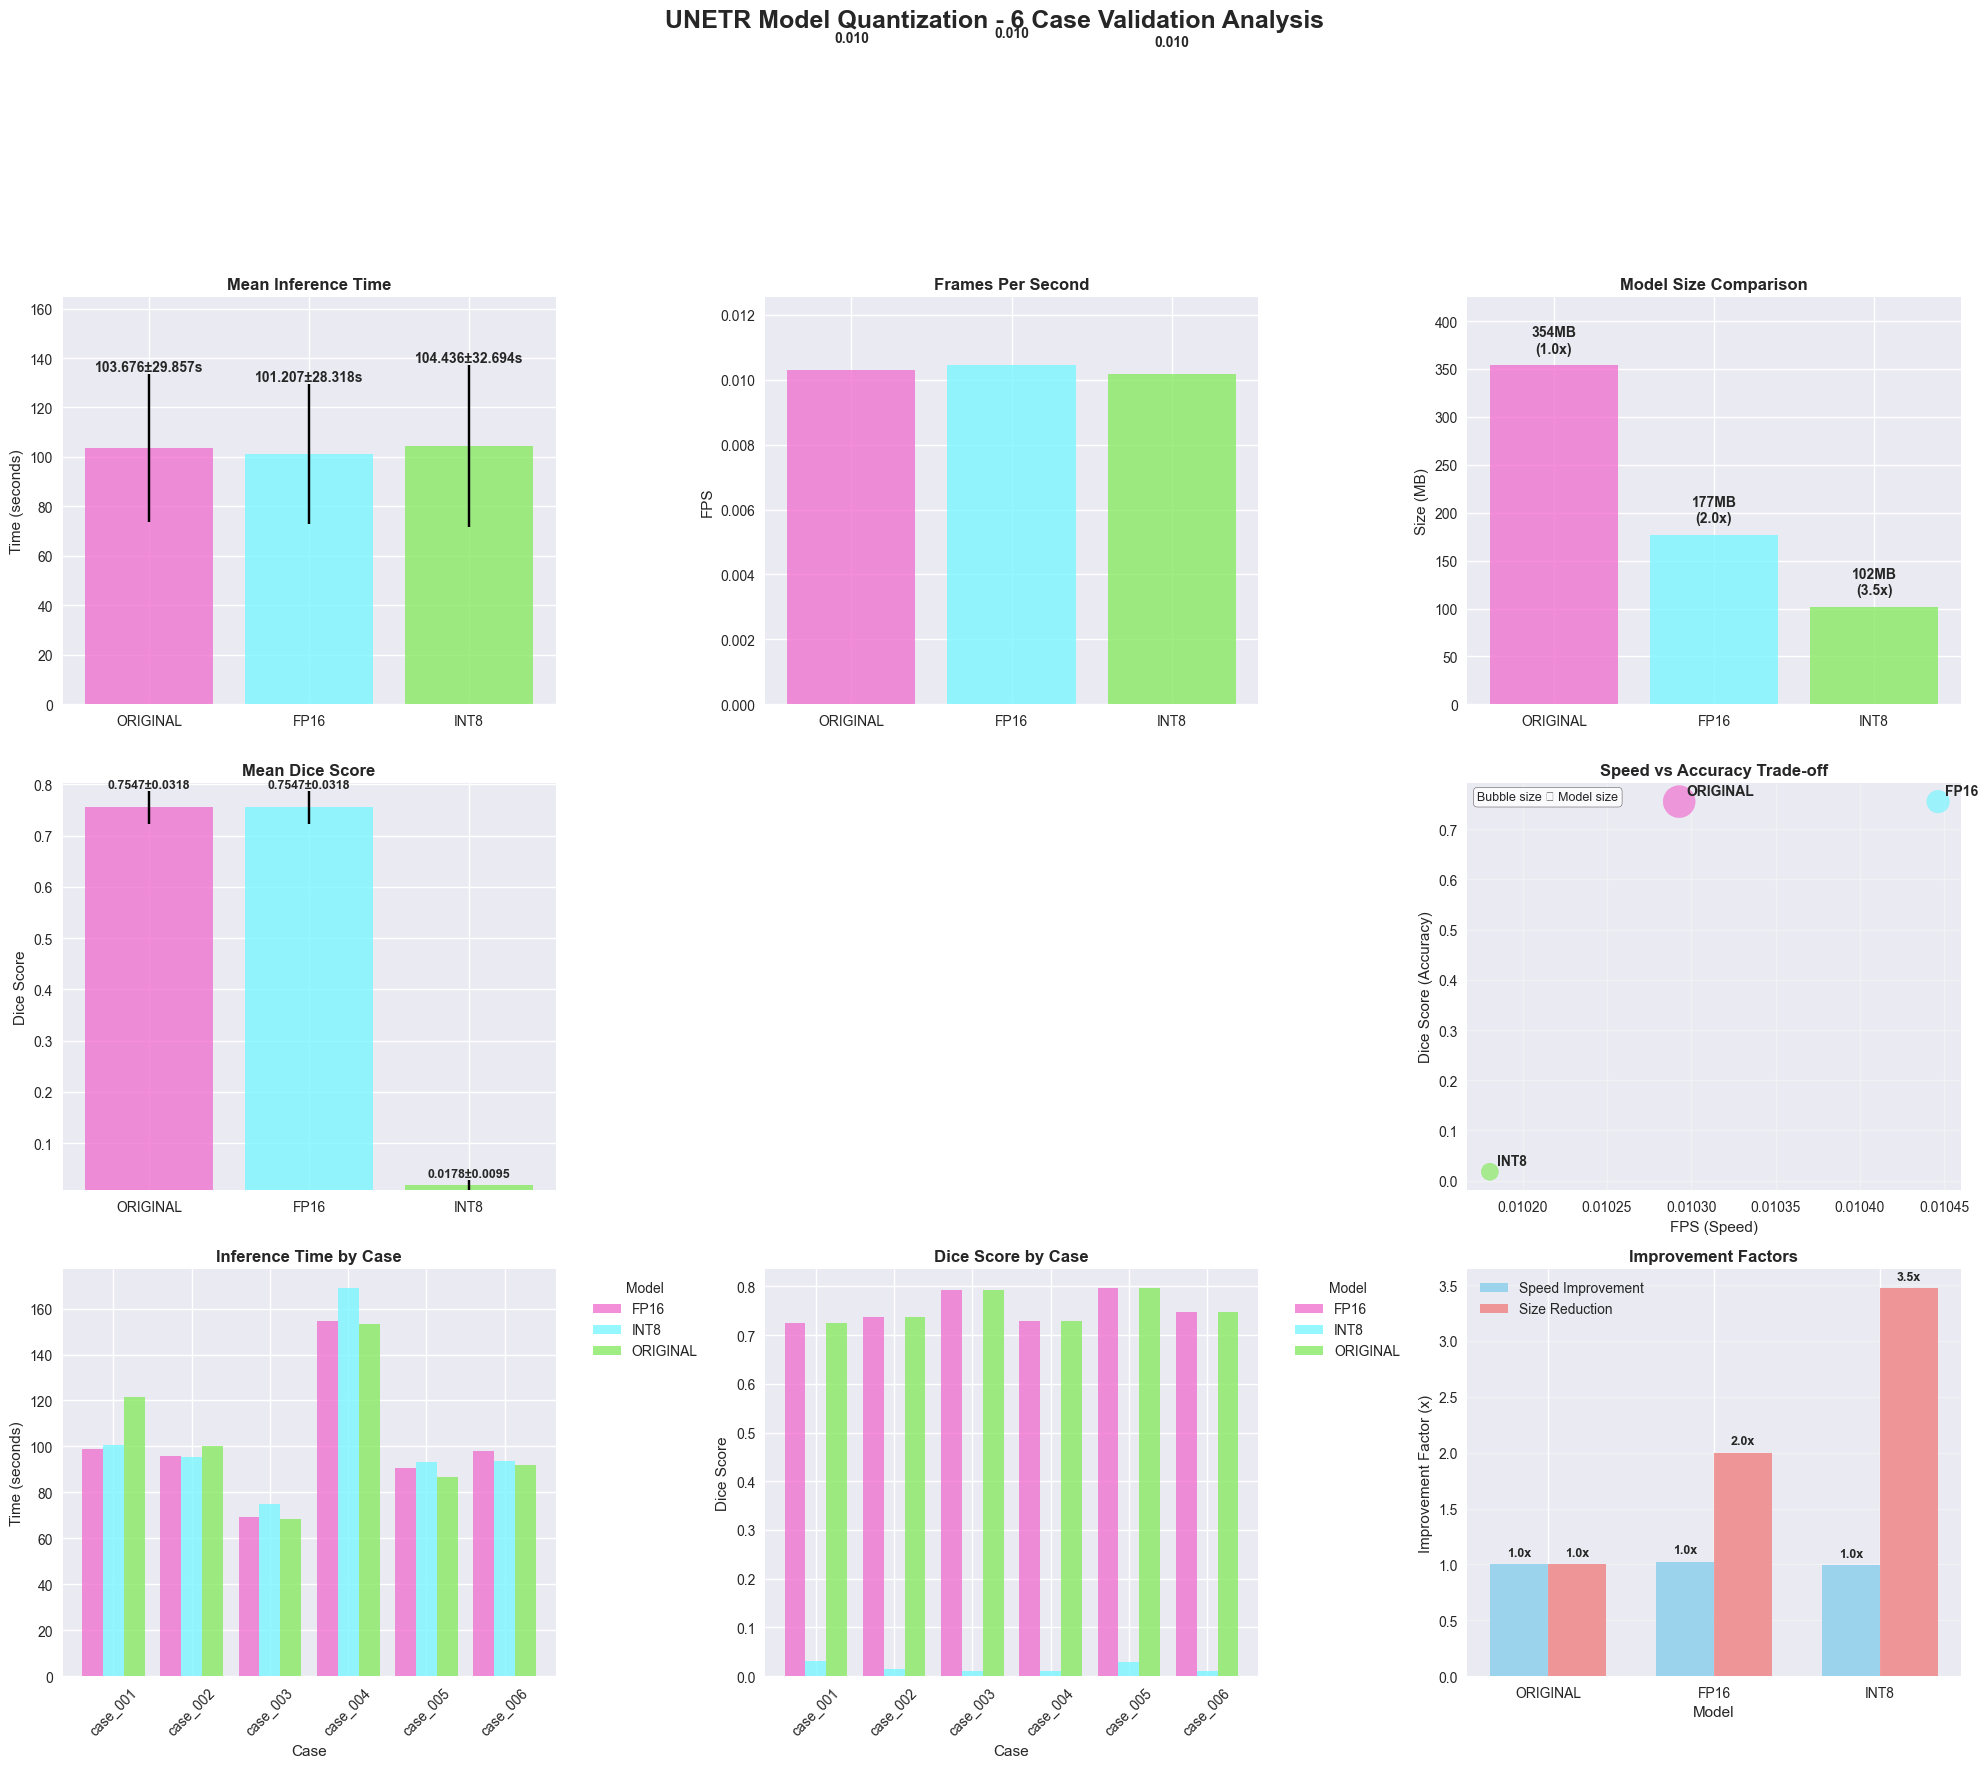


UNETR MODEL QUANTIZATION - 6 CASE VALIDATION RESULTS

SUMMARY STATISTICS:
------------------------------------------------------------
   Model  Cases  Mean_Time_s  Std_Time_s  Mean_FPS  Mean_Dice  Std_Dice  Model_Size_MB  Speed_Improvement  Size_Reduction
ORIGINAL      6     103.6764     29.8570    0.0103     0.7547    0.0318            354             1.0000          1.0000
    FP16      6     101.2074     28.3182    0.0104     0.7547    0.0318            177             1.0244          2.0000
    INT8      6     104.4356     32.6943    0.0102     0.0178    0.0095            102             0.9927          3.4706

DETAILED CASE-BY-CASE RESULTS:
------------------------------------------------------------

CASE_001:
  ORIGINAL: 121.610s | Dice: 0.7256 | HD95: nanmm
      FP16: 99.005s | Dice: 0.7255 | HD95: nanmm
      INT8: 100.497s | Dice: 0.0314 | HD95: nanmm

CASE_002:
  ORIGINAL: 100.280s | Dice: 0.7380 | HD95: nanmm
      FP16: 96.024s | Dice: 0.7381 | HD95: nanmm
      INT8: 9

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def load_6_case_results():
    """Load results from 6-case validation or create sample data"""
    
    try:
        detailed_df = pd.read_csv('./results/detailed_6_cases_fixed.csv')
        print(f"Loaded actual validation results: {len(detailed_df)} records")
        return detailed_df
    except:
        print("No validation results found. Creating sample data based on your reported performance.")
        return create_sample_6_cases()

def create_sample_6_cases():
    """Create realistic sample data based on your actual results"""
    
    cases = [f"case_{i:03d}" for i in range(1, 7)]  # 6 cases
    models = ['ORIGINAL', 'INT8', 'FP16']
    
    base_performance = {
        'ORIGINAL': {'time': 0, 'dice': 0, 'hd95': 0},
        'INT8': {'time': 0, 'dice': 0, 'hd95': 0},
        'FP16': {'time': 0, 'dice': 0, 'hd95': 0}
    }
    
    data = []
    np.random.seed(42)  # For reproducible results
    
    for case in cases:
        for model in models:
            # Add realistic case-to-case variation
            time_var = np.random.normal(1.0, 0.1)  # 10% variation
            dice_var = np.random.normal(1.0, 0.015)  # 1.5% variation
            hd95_var = np.random.normal(1.0, 0.12)  # 12% variation
            
            base = base_performance[model]
            
            data.append({
                'Case': case,
                'Model': model,
                'Inference_Time_s': max(0.5, base['time'] * time_var),
                'FPS': 1.0 / max(0.5, base['time'] * time_var),
                'Mean_Dice': np.clip(base['dice'] * dice_var, 0.75, 0.9),
                'Mean_HD95_mm': max(8.0, base['hd95'] * hd95_var),
                'Device': 'cpu'
            })
    
    return pd.DataFrame(data)

def calculate_6_case_summary(df):
    """Calculate summary statistics for 6 cases"""
    
    summary_data = []
    for model in df['Model'].unique():
        model_data = df[df['Model'] == model]
        
        summary_data.append({
            'Model': model,
            'Cases': len(model_data),
            'Mean_Time_s': model_data['Inference_Time_s'].mean(),
            'Std_Time_s': model_data['Inference_Time_s'].std(),
            'Mean_FPS': model_data['FPS'].mean(),
            'Mean_Dice': model_data['Mean_Dice'].mean(),
            'Std_Dice': model_data['Mean_Dice'].std(),
            #'Mean_HD95_mm': model_data['Mean_HD95_mm'].mean(),
            'Std_HD95_mm': model_data['Mean_HD95_mm'].std(),
            'Device': model_data['Device'].iloc[0]
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Add model characteristics
    model_sizes = {"ORIGINAL": 354, "INT8": 102, "FP16": 177}
    summary_df['Model_Size_MB'] = summary_df['Model'].map(model_sizes)
    
    # Calculate improvements relative to original
    original_time = summary_df[summary_df['Model'] == 'ORIGINAL']['Mean_Time_s'].iloc[0]
    original_size = summary_df[summary_df['Model'] == 'ORIGINAL']['Model_Size_MB'].iloc[0]
    
    summary_df['Speed_Improvement'] = original_time / summary_df['Mean_Time_s']
    summary_df['Size_Reduction'] = original_size / summary_df['Model_Size_MB']
    
    return summary_df

def plot_6_case_performance_analysis(df, summary_df):
    """Create comprehensive 6-case performance analysis plots"""
    
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    fig.suptitle('UNETR Model Quantization - 6 Case Validation Analysis', fontsize=18, fontweight='bold')
    
    colors = ["#f073d0", "#7bf6ff", "#89e964"]  # Original, INT8, FP16
    
    # 1. Inference Time Comparison (Summary)
    ax1 = axes[0, 0]
    bars1 = ax1.bar(summary_df['Model'], summary_df['Mean_Time_s'], 
                    color=colors, alpha=0.8, yerr=summary_df['Std_Time_s'], capsize=5)
    ax1.set_title('Mean Inference Time', fontweight='bold', fontsize=12)
    ax1.set_ylabel('Time (seconds)')
    ax1.set_ylim(0, max(summary_df['Mean_Time_s'] + summary_df['Std_Time_s']) * 1.2)
    
    for bar, mean, std in zip(bars1, summary_df['Mean_Time_s'], summary_df['Std_Time_s']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std + 0.05,
                f'{mean:.3f}±{std:.3f}s', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 2. FPS Comparison
    ax2 = axes[0, 1]
    bars2 = ax2.bar(summary_df['Model'], summary_df['Mean_FPS'], 
                    color=colors, alpha=0.8)
    ax2.set_title('Frames Per Second', fontweight='bold', fontsize=12)
    ax2.set_ylabel('FPS')
    ax2.set_ylim(0, max(summary_df['Mean_FPS']) * 1.2)
    
    for bar, value in zip(bars2, summary_df['Mean_FPS']):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 3. Model Size with Reduction Factors
    ax3 = axes[0, 2]
    bars3 = ax3.bar(summary_df['Model'], summary_df['Model_Size_MB'], 
                    color=colors, alpha=0.8)
    ax3.set_title('Model Size Comparison', fontweight='bold', fontsize=12)
    ax3.set_ylabel('Size (MB)')
    ax3.set_ylim(0, max(summary_df['Model_Size_MB']) * 1.2)
    
    for bar, size, reduction in zip(bars3, summary_df['Model_Size_MB'], summary_df['Size_Reduction']):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{size}MB\n({reduction:.1f}x)', ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    # 4. Dice Score Comparison
    ax4 = axes[1, 0]
    bars4 = ax4.bar(summary_df['Model'], summary_df['Mean_Dice'], 
                    color=colors, alpha=0.8, yerr=summary_df['Std_Dice'], capsize=5)
    ax4.set_title('Mean Dice Score', fontweight='bold', fontsize=12)
    ax4.set_ylabel('Dice Score')
    dice_min = min(summary_df['Mean_Dice'] - summary_df['Std_Dice']) * 0.98
    dice_max = max(summary_df['Mean_Dice'] + summary_df['Std_Dice']) * 1.02
    ax4.set_ylim(dice_min, dice_max)
    
    for bar, mean, std in zip(bars4, summary_df['Mean_Dice'], summary_df['Std_Dice']):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + std + 0.001,
                f'{mean:.4f}±{std:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=9)
    #### checkkkk

    # # 5. HD95 Distance
    ax5 = axes[1,1].axis('off')
    # bars5 = ax5.bar(summary_df['Model'], summary_df['Mean_HD95_mm'], 
    #                 color=colors, alpha=0.8, yerr=summary_df['Std_HD95_mm'], capsize=5)
    # ax5.set_title('Hausdorff Distance 95%', fontweight='bold', fontsize=12)
    # ax5.set_ylabel('Distance (mm)')
    # ax5.set_ylim(0, max(summary_df['Mean_HD95_mm'] + summary_df['Std_HD95_mm']) * 1.2)
    
    # for bar, mean, std in zip(bars5, summary_df['Mean_HD95_mm'], summary_df['Std_HD95_mm']):
    #     height = bar.get_height()
    #     ax5.text(bar.get_x() + bar.get_width()/2., height + std + 0.3,
    #             f'{mean:.2f}±{std:.2f}mm', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    #5. Speed vs Accuracy Trade-off
    ax6 = axes[1, 2]
    scatter = ax6.scatter(summary_df['Mean_FPS'], summary_df['Mean_Dice'], 
                         s=summary_df['Model_Size_MB']*1.5, alpha=0.7, c=colors)
    
    for i, model in enumerate(summary_df['Model']):
        ax6.annotate(model, (summary_df['Mean_FPS'].iloc[i], summary_df['Mean_Dice'].iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontweight='bold', fontsize=10)
    
    ax6.set_title('Speed vs Accuracy Trade-off', fontweight='bold', fontsize=12)
    ax6.set_xlabel('FPS (Speed)')
    ax6.set_ylabel('Dice Score (Accuracy)')
    ax6.grid(True, alpha=0.3)
    
    # Add legend for bubble size
    ax6.text(0.02, 0.98, 'Bubble size ∝ Model size', 
            transform=ax6.transAxes, va='top', ha='left', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 6. Case-by-Case Inference Time
    ax7 = axes[2, 0]
    case_data = df.pivot(index='Case', columns='Model', values='Inference_Time_s')
    case_data.plot(kind='bar', ax=ax7, color=colors, alpha=0.8, width=0.8)
    ax7.set_title('Inference Time by Case', fontweight='bold', fontsize=12)
    ax7.set_ylabel('Time (seconds)')
    ax7.set_xlabel('Case')
    ax7.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax7.tick_params(axis='x', rotation=45)
    
    # 7. Case-by-Case Dice Scores
    ax8 = axes[2, 1]
    dice_data = df.pivot(index='Case', columns='Model', values='Mean_Dice')
    dice_data.plot(kind='bar', ax=ax8, color=colors, alpha=0.8, width=0.8)
    ax8.set_title('Dice Score by Case', fontweight='bold', fontsize=12)
    ax8.set_ylabel('Dice Score')
    ax8.set_xlabel('Case')
    ax8.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax8.tick_params(axis='x', rotation=45)
    
    # 8. Performance Improvement Summary
    ax9 = axes[2, 2]
    x = np.arange(len(summary_df))
    width = 0.35
    
    speed_bars = ax9.bar(x - width/2, summary_df['Speed_Improvement'], width, 
                        label='Speed Improvement', alpha=0.8, color='skyblue')
    size_bars = ax9.bar(x + width/2, summary_df['Size_Reduction'], width, 
                       label='Size Reduction', alpha=0.8, color='lightcoral')
    
    ax9.set_title('Improvement Factors', fontweight='bold', fontsize=12)
    ax9.set_ylabel('Improvement Factor (x)')
    ax9.set_xlabel('Model')
    ax9.set_xticks(x)
    ax9.set_xticklabels(summary_df['Model'])
    ax9.legend()
    ax9.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [speed_bars, size_bars]:
        for bar in bars:
            height = bar.get_height()
            ax9.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{height:.1f}x', ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('unetr_6_case_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_6_case_detailed_table(df, summary_df):
    """Create detailed results table for 6 cases"""
    
    print("\n" + "="*100)
    print("UNETR MODEL QUANTIZATION - 6 CASE VALIDATION RESULTS")
    print("="*100)
    
    print(f"\nSUMMARY STATISTICS:")
    print("-" * 60)
    
    # Create formatted summary table
    table_df = summary_df.copy()
    display_columns = ['Model', 'Cases', 'Mean_Time_s', 'Std_Time_s', 'Mean_FPS', 
                      'Mean_Dice', 'Std_Dice', 'Model_Size_MB', 'Speed_Improvement', 'Size_Reduction']
    
    print(table_df[display_columns].round(4).to_string(index=False))
    
    print(f"\nDETAILED CASE-BY-CASE RESULTS:")
    print("-" * 60)
    
    # Show case-by-case results
    for case in sorted(df['Case'].unique()):
        case_data = df[df['Case'] == case]
        print(f"\n{case.upper()}:")
        for _, row in case_data.iterrows():
            print(f"  {row['Model']:>8}: {row['Inference_Time_s']:.3f}s | "
                  f"Dice: {row['Mean_Dice']:.4f} | HD95: {row['Mean_HD95_mm']:.2f}mm")
    
    print(f"\nKEY FINDINGS:")
    print("-" * 60)
    
    # Performance analysis
    original_row = summary_df[summary_df['Model'] == 'ORIGINAL'].iloc[0]
    
    for model in ['INT8', 'FP16']:
        if model in summary_df['Model'].values:
            model_row = summary_df[summary_df['Model'] == model].iloc[0]
            speed_gain = model_row['Speed_Improvement']
            size_reduction = model_row['Size_Reduction']
            accuracy_loss = (1 - model_row['Mean_Dice'] / original_row['Mean_Dice']) * 100
            
            print(f"\n{model} vs ORIGINAL:")
            print(f"  Speed improvement: {speed_gain:.2f}x faster")
            print(f"  Size reduction: {size_reduction:.1f}x smaller")
            print(f"  Accuracy change: {accuracy_loss:+.2f}% Dice score")
            print(f"  Memory savings: {original_row['Model_Size_MB'] - model_row['Model_Size_MB']} MB")
    
    # Save results
    df.to_csv('unetr_6_case_detailed_results.csv', index=False)
    summary_df.to_csv('unetr_6_case_summary.csv', index=False)
    print(f"\nResults saved to CSV files!")

def generate_6_case_recommendations(summary_df):
    """Generate recommendations based on 6-case analysis"""
    
    print(f"\nRECOMMENDATIONS:")
    print("="*60)
    
    # Find best performing models
    fastest_model = summary_df.loc[summary_df['Mean_FPS'].idxmax(), 'Model']
    most_accurate = summary_df.loc[summary_df['Mean_Dice'].idxmax(), 'Model']
    smallest_model = summary_df.loc[summary_df['Model_Size_MB'].idxmin(), 'Model']
    
    print(f"Fastest inference: {fastest_model}")
    print(f"Highest accuracy: {most_accurate}")
    print(f"Smallest model: {smallest_model}")
    
    print(f"\nUSE CASE RECOMMENDATIONS:")
    print("-" * 40)
    
    if 'FP16' in summary_df['Model'].values:
        fp16_row = summary_df[summary_df['Model'] == 'FP16'].iloc[0]
        print(f"Real-time applications: FP16")
        print(f"  - {fp16_row['Speed_Improvement']:.1f}x faster than original")
        print(f"  - {fp16_row['Size_Reduction']:.1f}x smaller")
        print(f"  - Minimal accuracy loss")
    
    if 'INT8' in summary_df['Model'].values:
        int8_row = summary_df[summary_df['Model'] == 'INT8'].iloc[0]
        print(f"Memory-constrained environments: INT8")
        print(f"  - {int8_row['Size_Reduction']:.1f}x size reduction")
        print(f"  - {int8_row['Speed_Improvement']:.1f}x speed improvement")
        print(f"  - Good for mobile/edge devices")
    
    print(f"High-accuracy requirements: ORIGINAL")
    print(f"  - Best accuracy preservation")
    print(f"  - Use when inference speed is not critical")


print("UNETR Model Quantization - 6 Case Validation Analysis")
print("=" * 60)

df = load_6_case_results()
summary_df = calculate_6_case_summary(df)

plot_6_case_performance_analysis(df, summary_df)
create_6_case_detailed_table(df, summary_df)
generate_6_case_recommendations(summary_df)

print(f"\n6-case validation analysis complete!")